In [1]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

There are 7578 names: 
_Godwin#
_Gwenni#
_Cam#
_Emmery#
_Ernie#
_Bellamy#
_Christof#
_Cammy#


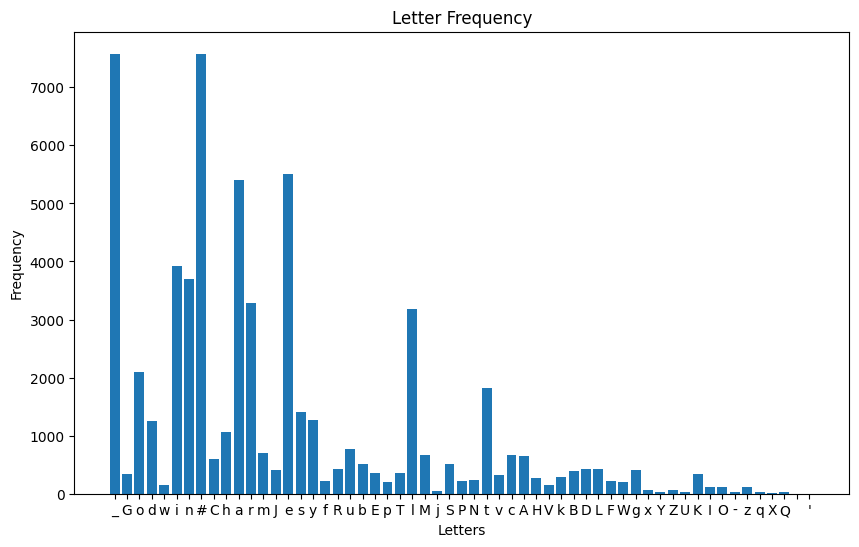

In [2]:
import os
start_token = "_"
eos = '#'

with open("../names") as f:
    names = f.readlines()
    names = [start_token + name.strip() + eos for name in names]

names = list(set(names))  # в датасете есть повторы
print(f'There are {len(names)} names: ')
for x in names[::1000]:
    print(x)

# TODO: постройте частоты употреблений букв
# Подсчет частоты употребления букв
letter_freq = Counter(''.join(names))

# Визуализация частоты употребления букв
plt.figure(figsize=(10, 6))
plt.bar(letter_freq.keys(), letter_freq.values())
plt.xlabel('Letters')
plt.ylabel('Frequency')
plt.title('Letter Frequency')
plt.show()
# HINT: для графика возьмите plt.bar

max length = 17


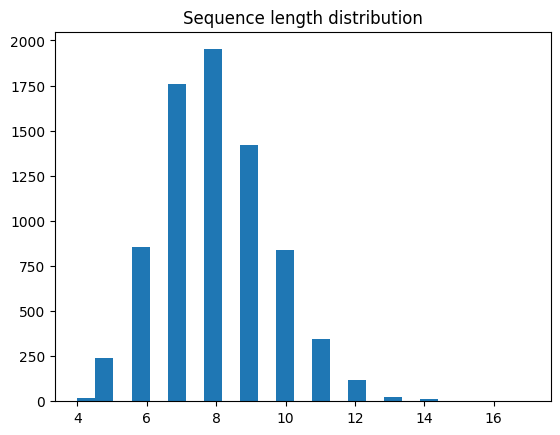

In [3]:
# в датасете есть слова с разными длинами
MAX_LENGTH = max(map(len,names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len,names)), bins=25);

In [4]:
names[:10]

['_Godwin#',
 '_Charmian#',
 '_Jessey#',
 '_Godfree#',
 '_Rubi#',
 '_Griffin#',
 '_Euphemia#',
 '_Tilda#',
 '_Marje#',
 '_Trina#']

In [5]:
# TODO: отберите уникальные токены и заполните два словаря для конвертации токенов <-> индексы
# сделайте так, чтобы start_token имел номер 0
    
tokens = sorted(set(''.join(names)))

tokens.remove(start_token)
tokens = [start_token] + tokens

tok2id = {tok: i for i, tok in enumerate(tokens)}
id2tok = {i: tok for i, tok in enumerate(tokens)}

n_tokens = len(tokens)
print (f'There are {n_tokens} tokens')

assert 50 < n_tokens < 60

print('Vocabular: ' + "".join(tokens))

There are 57 tokens
Vocabular: _ #'-ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [6]:
def to_matrix(names, max_len=None, pad=tok2id[' '], dtype=np.int64):
    """Casts a list of names into matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(tok2id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [7]:
print('\n'.join(names[:10]))
print(to_matrix(names[:10]))

_Godwin#
_Charmian#
_Jessey#
_Godfree#
_Rubi#
_Griffin#
_Euphemia#
_Tilda#
_Marje#
_Trina#
[[ 0 11 45 34 53 39 44  2  1  1]
 [ 0  7 38 31 48 43 39 31 44  2]
 [ 0 14 35 49 49 35 55  2  1  1]
 [ 0 11 45 34 36 48 35 35  2  1]
 [ 0 22 51 32 39  2  1  1  1  1]
 [ 0 11 48 39 36 36 39 44  2  1]
 [ 0  9 51 46 38 35 43 39 31  2]
 [ 0 24 39 42 34 31  2  1  1  1]
 [ 0 17 31 48 40 35  2  1  1  1]
 [ 0 24 48 39 44 31  2  1  1  1]]


In [8]:
# TODO: разбейте все имена на тренировочную (80%) и тестовую часть (20%)
def split_data(names):
    train_size = int(len(names) * 0.8)
    train_data = names[:train_size]
    val_data = names[train_size:]
    return train_data, val_data

In [9]:
train_data, val_data = split_data(names)

len(train_data), len(val_data)

(6062, 1516)

# Char-Transformer для имен

Вам нужно написать сеть, кодирующую входные символы и их позиции с помощью таблиц Embeddings. 
Получившиеся тензоры пропустить через `TransformerEncoder`, затем преобразовать в логиты для предсказания новых символов.

Transformer может обрабатывать сразу всю последовательность за один проход. Для того, чтобы у модели не было возможности "заглянуть в будущее", то есть использовать информацию о впреди идущих символах, необходимо сгенерировать маску. `TransformerEncoder` должен принимать на вход последовательность символов и маску.    

In [10]:
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
from IPython.display import clear_output

In [11]:
# TODO: заполните пропуски

class NameTransformer(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, n_layers=2, n_head=2, dropout=0.1):
        super(NameTransformer, self).__init__()
        self.vocab_size = vocab_size
        
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.pos_emb = nn.Embedding(MAX_LENGTH, emb_size)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=emb_size,
                nhead=n_head,
                dim_feedforward=hidden_size,
                dropout=dropout
            ),
            num_layers=n_layers
        )
        self.linear = nn.Linear(emb_size, vocab_size)
        
        self.register_buffer("position_ids", torch.arange(MAX_LENGTH).unsqueeze(1))

    def _generate_square_subsequent_mask(self, seq_len):
        # TODO: сгенерируйте маску размера seq_len x seq_len
        # если во время кодирования i-го символа j-й символ доступен, 
        # то (i,j) элемент маски равен 0, иначе -inf
        
        mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

        return mask
        
    def forward(self, input):

        batch_size, seq_len = input.size()
        pos = self.position_ids[:seq_len].expand(batch_size, seq_len).to(input.device) #########################
        print(self.emb(input).shape)
        print(self.pos_emb(pos).shape)
        x = self.emb(input) + self.pos_emb(pos)
        mask = self._generate_square_subsequent_mask(seq_len).to(input.device)
        x = self.transformer_encoder(x.transpose(0, 1), mask).transpose(0, 1)
        output = F.log_softmax(self.linear(x), dim=-1)

        return output

# Код для тренировки

In [12]:
def train_epoch(model, optimizer, train_batches):
    loss_log = []
    model.train()
    
    for batch in train_batches:
        
        nums = to_matrix(batch)
        
        nums = torch.from_numpy(nums)
        
        optimizer.zero_grad()
        output = model(nums)
        
        # Посчитаем потери и выполним обратное распространение градиентов
        loss = F.nll_loss(output[:, :-1, :].reshape(-1, output.size(-1)), nums[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
            
        loss = loss.item()
        loss_log.append(loss)
    return loss_log   

def test(model, test_batches):
    loss_log = []
    model.eval()
    for batch in test_batches:  
        
        nums = to_matrix(batch)
        
        nums = torch.from_numpy(nums)
        output = model(nums)

        # Вычислим потери для тестовой выборки
        loss = F.nll_loss(output[:, :-1, :].reshape(-1, output.size(-1)), nums[:, 1:].reshape(-1))
            
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    val_log = []
    
    bs = 32
    total_steps = 0
    train_batches = np.array_split(train_data, len(train_data) // bs)
    test_batches = np.array_split(val_data, len(val_data) // bs)
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt, train_batches)
        train_log.extend(train_loss)
        total_steps += len(train_batches)
        
        val_loss = test(model, test_batches)
        train_log.extend(train_loss)
        
        val_log.append((len(train_log), np.mean(val_loss)))
        
        clear_output()
        plot_history(train_log, val_log)

In [13]:
model = NameTransformer(len(tokens), 64, 64, n_layers=2, n_head=2, dropout=0.1)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, opt, 5)

S:\study\Python\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
S:\study\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: The expanded size of the tensor (33) must match the existing size (10) at non-singleton dimension 0.  Target sizes: [33, 10].  Tensor sizes: [10, 1]

# Генерация по argmax

In [ ]:
# Напишите функцию генерации продолжения строки
def pick_by_argmax(logits):
    return torch.argmax(logits, dim=-1)

def ids2string(ids):
    return "".join(id2tok[_] for _ in ids)


def gen_continuation(model, prefix="_"):
    nums = to_matrix(prefix)
    nums = torch.from_numpy(nums)
    
    # TODO: сначала подайте на вход префикс
    # нас интересует последний output, чтобы получить первое предсказание
    with torch.no_grad():
        model.eval()
        prefix_tensor = nums.unsqueeze(0)  # Добавляем размерность пакета
        
        # Сначала подаем на вход префикс и сохраняем последний output
        output = model(prefix_tensor)
        last_output = output[:, -1:, :]  # Последний output в последовательности
    # TODO: затем сгенерируйте несколько последующих символов
    # outs -- это массив с номерами токенов
        # Затем сгенерируем несколько последующих символов
        continuation_ids = []
        for _ in range(MAX_LENGTH):
            # Подаем последний output на вход модели
            next_logits = model(last_output)
            
            # Выбираем следующий символ по argmax
            next_id = pick_by_argmax(next_logits)
            
            # Добавляем выбранный символ к последовательности
            continuation_ids.append(next_id.item())
            
            # Создаем новый input для следующей итерации
            last_output = next_logits[:, -1:, :]  # Последний output в последовательности
        
        # Преобразуем индексы в строку
        continuation_string = ids2string(continuation_ids)
    
        print(prefix + '|'+ ids2string(outs))
    
gen_continuation(model, " Ku")

ValueError: too many values to unpack (expected 2)